Load the data.

Report: https://docs.google.com/document/d/1y1XSL5tRy91a2g2LWPyvDZDbgZ1tkxSpI64DL-aLQsg/edit?usp=sharing

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = []
names = ["alternative.csv", "blues.csv", "childrens music.csv", 
         "comedy.csv", "electronic.csv", "folk.csv", "hip-hop.csv", 
         "movie.csv", "ska.csv", "soul.csv"]

for i in range(len(names)):
    df.append( pd.read_csv("training-data/" + names[i], header = 0) )
    
df = pd.concat(df, ignore_index=True)

# export to csv bc i'm lazy and don't want to load every single one.
df.to_csv('training-data/all.csv', sep = ',', index = False)

General table information

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  int64  
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   track_id          50000 non-null  object 
 4   popularity        50000 non-null  int64  
 5   acousticness      50000 non-null  float64
 6   danceability      50000 non-null  float64
 7   duration_ms       50000 non-null  int64  
 8   energy            50000 non-null  float64
 9   instrumentalness  50000 non-null  float64
 10  key               50000 non-null  object 
 11  liveness          50000 non-null  float64
 12  loudness          50000 non-null  float64
 13  mode              50000 non-null  object 
 14  speechiness       50000 non-null  float64
 15  tempo             50000 non-null  object 
 16  time_signature    50000 non-null  object

The data contains 17 features, the id and the genre. Of those, every feature has every piece of information (meaning no missing data), there are 8 categorical features and 11 numerical or continuous features. There are 5000 instances in the data set. However, further processing will show that there *are* missing features: for example, the duration is set to -1 for some, which is impossible and thus missing data.

instance_id is a unique id for each instance. It needs to be kept for the Kaggle competition.

artist_name has an option for empty_field. A Google search shows no artist with that name; that's missing data. There is an unlimited number of artists possible, so there's no way to interpolate that correctly, as it may be someone not in the data set. While it may help to connect an artist to what their primary genre is, we do not have the data on every single artist in the world, meaning it's impossible to use the data for that. It'll be dropped.

track_name does not appear to have missing values. That being said, it'd be very hard to encode, as almost every title track is unique. This may provide a hint on what the song is about (love, ...), which may contribute to the algorithm, but for now, I will be dropping this column for a "minimum viable product" type of report; if I have time, I'll add it later.

The track ID appears to be another unique identifier for the instance, potentially linking it to an mp3 file, or similar. We were not given that, and thus, I decided to drop it.

Popularity will be standardised, as will acoutstiness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, speechiness, tempo, valence, as all are numerical values that may contribute to finding the genre.

Mode and key are a special situation: the data set actually does a mistake, as C Minor and C Major are not the same key (quoting Wikipedia: "The key may be in the major or minor mode, though musicians assume major when this is not specified, e.g., "This piece is in C" implies that the key of the song is C major. Popular songs are usually in a key, and so is classical music during the common practice period, around 1650–1900. Longer pieces in the classical repertoire may have sections in contrasting keys." (https://en.wikipedia.org/wiki/Key_(music) on 10/09/2022) and my Piano teacher), and thus, I intend to merge them into one column, and then  encode them. However, major/minor does introduce a general mood to the piece of music (happy versus mellow, for example), and I will ALSO keep it as its own column. However, sicne C Minor and C Major are different keys, I'll keep them sepperate. 

Tempo signature needs to be changed. It's currently a date, when in fact, the correct display would be 4/4, ... Now, 4/4 and 2/2 may both equal 1, but musically, they're not the same, as 4/4 puts more emphasis on the 3rd beat, which 2/2 doesn't do. This needs to be encoded; whenever categorical or ordinal. On the other hand, it can be argued that the difference is minimal, and thus, just using a float of the division may work. Ultimatively, due to time constraints, I decided to drop the feature, and only return to it if I had time.

In [96]:
columnsToDrop = ['artist_name', 'track_name', 'track_id', 'time_signature']
columnsToKeep = ['instance_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key', 'mode']
columnsScaled = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'] 

In [98]:
from sklearn import preprocessing

# drop columns
df = df.drop(columnsToDrop, axis=1)

# drop all instances missing data
df = df[df.tempo != '?']
    
# turn key into key with mode + ordinally encode @TODO
df['key'] = df['key'] + df['mode']
dummies = pd.get_dummies(df.key)       # for now; will change to ordinal when i figure out how @TODO
df = pd.concat([df, dummies], axis=1) 

# encoce major/minor into binary
modeEncoder = preprocessing.LabelEncoder()
df['mode'] = modeEncoder.fit_transform(df['mode'])

# one hot encode genre
# i am doing this for correlation
dummies = pd.get_dummies(df.genre)
df = pd.concat([df, dummies], axis=1)

# also label encode
# encoce major/minor into binary
genreEncoder = preprocessing.LabelEncoder()
df['genre_label'] = genreEncoder.fit_transform(df['genre'])

# interpolate duration
df['duration_ms'] = df['duration_ms'].replace('-1',  np.nan)
df['duration_ms'] = df['duration_ms'].interpolate()

# scale
scalers = []

for col in columnsScaled: 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(df[[col]])
    df[[col]] = x_scaled
    scalers.append(min_max_scaler)
    

df.head()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,genre,A#Major,A#Minor,AMajor,AMinor,BMajor,BMinor,C#Major,C#Minor,CMajor,CMinor,D#Major,D#Minor,DMajor,DMinor,EMajor,EMinor,F#Major,F#Minor,FMajor,FMinor,G#Major,G#Minor,GMajor,GMinor,Alternative,Blues,Children's Music,Comedy,Electronic,Folk,Hip-Hop,Movie,Ska,Soul,genre_label
0,50010,0.447917,0.225903,0.844710,0.049410,0.746692,0.000089,FMinor,0.066930,0.777217,1,0.017077,0.516157,0.961,Alternative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,50011,0.489583,0.667670,0.863043,0.034396,0.342200,0.000082,A#Minor,0.090725,0.671976,1,0.034896,0.516273,0.177,Alternative,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,50012,0.500000,0.238955,0.569719,0.045419,0.517413,0.000000,AMajor,0.171729,0.692266,0,0.009546,0.256895,0.566,Alternative,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,50013,0.625000,0.000076,0.336784,0.000000,0.971966,0.000000,BMinor,0.313487,0.809713,1,0.050382,0.345321,0.701,Alternative,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,50014,0.604167,0.002740,0.417664,0.000000,0.971966,0.000000,A#Major,0.130215,0.824504,0,0.026941,0.590422,0.414,Alternative,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


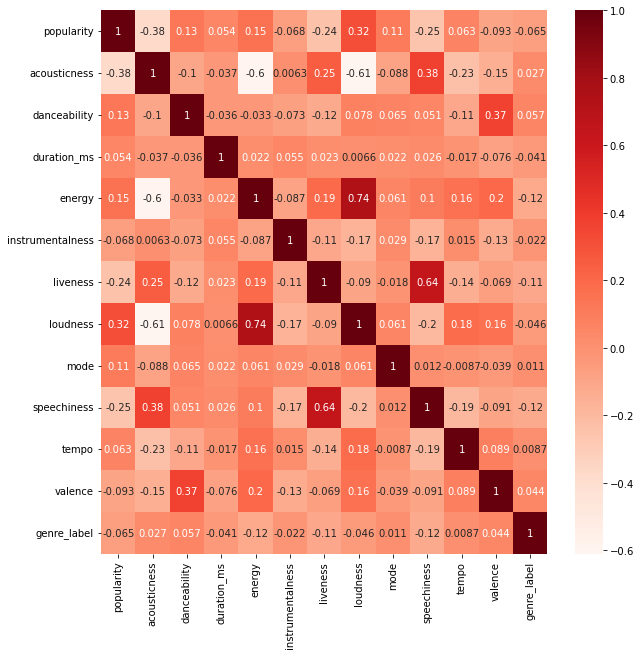

In [107]:
# heat map showing correlation between multiple features (ignoring the one hot encoded features)
plt.figure(figsize=(10,10))
smaller = df[['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode','speechiness', 'tempo', 'valence', 'genre_label']]
cor = smaller.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


This heat map shows especially strong correlation between energy and loudness (to be expected; loud music is usually considered energetic) and high speechiness and liveness (also to be espected). Comparing the difference in other correlations between energy and loudness shows similar results, but in my opinion, they are different enough (especially in liveness, instrumentalness, and accoutsticness, as well as popularity) that they do not warrant one of them being removed. The same applies to speechiness and liveness. 

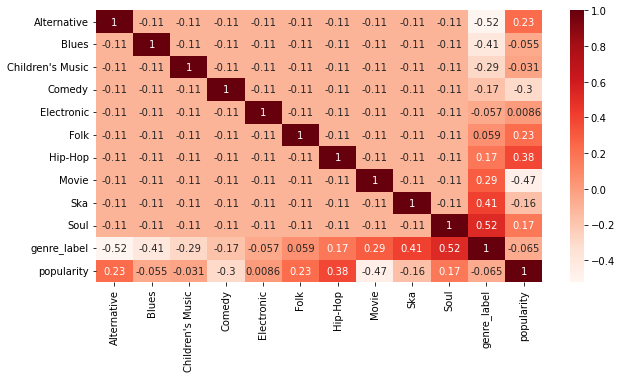

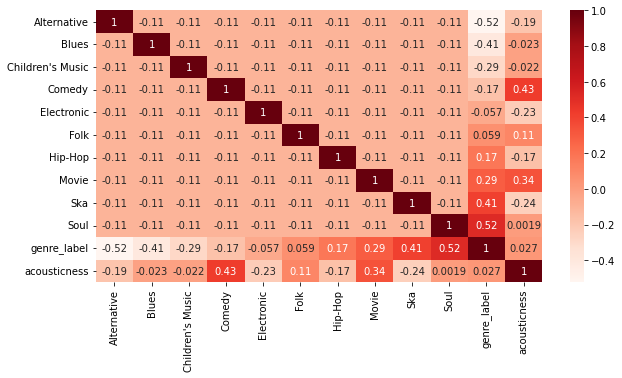

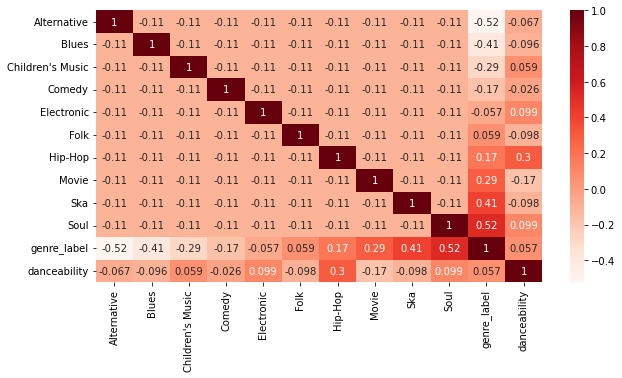

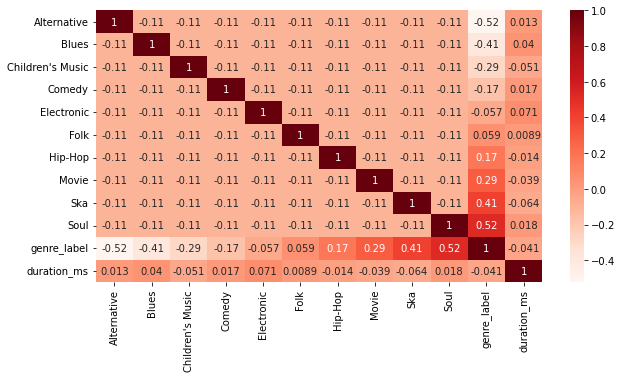

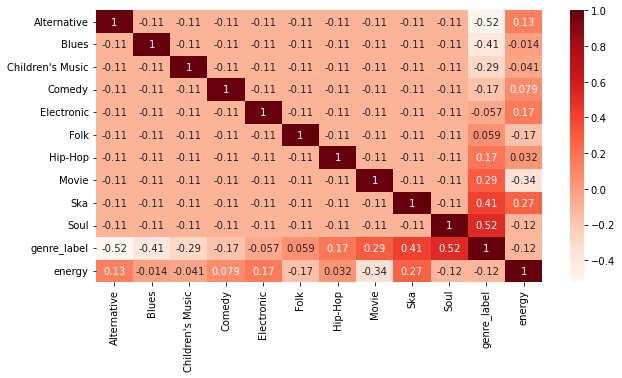

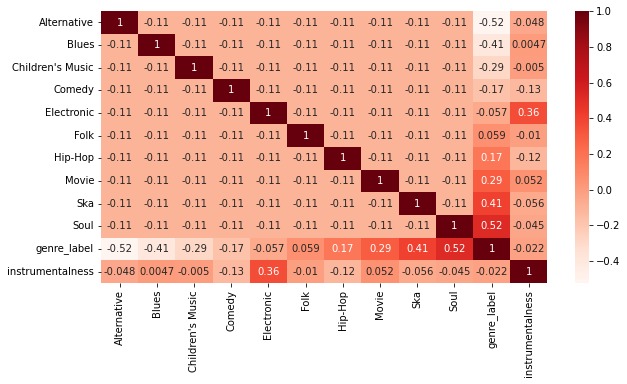

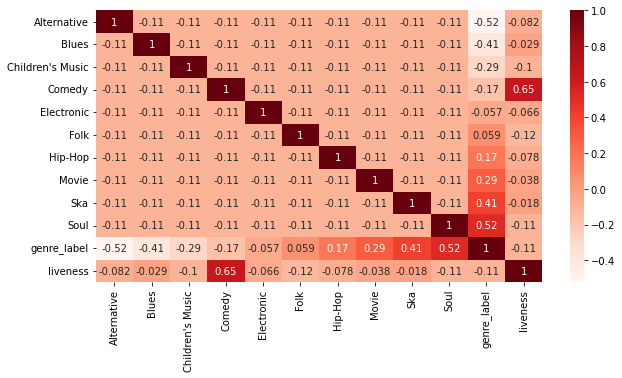

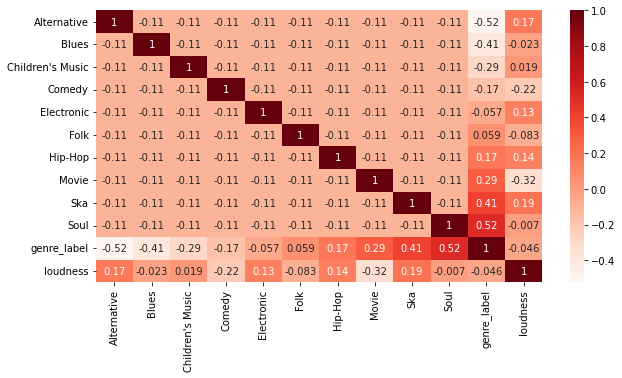

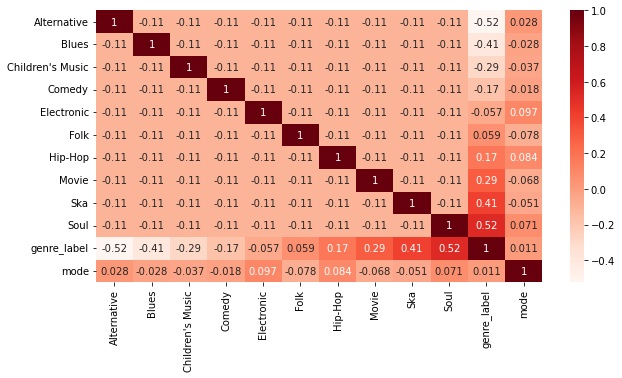

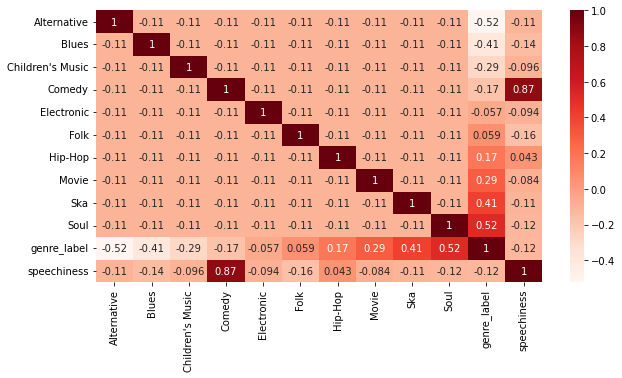

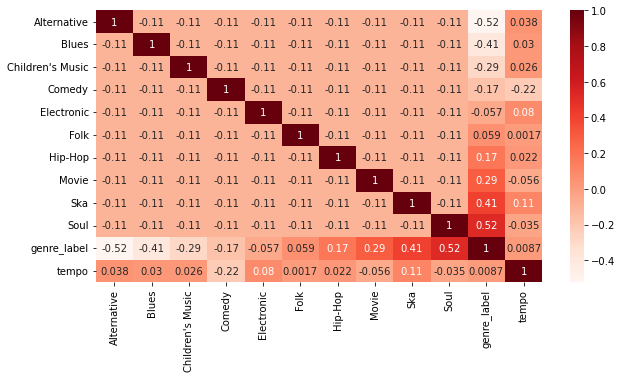

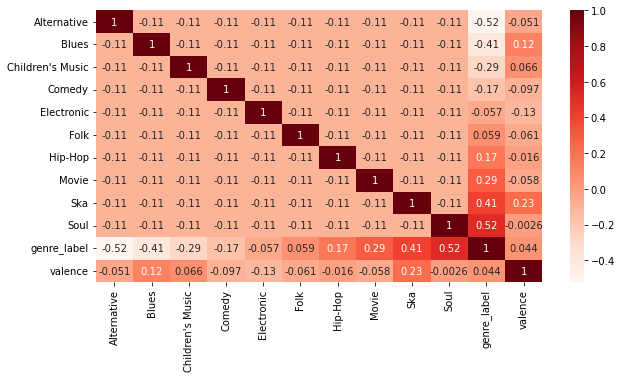

In [111]:
# linking each numeric features w/ the genres

numericFeatures = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode','speechiness', 'tempo', 'valence']

# heat map showing correlation between multiple features (ignoring the one hot encoded features)
for f in numericFeatures:
    plt.figure(figsize=(10,5))
    features = ['Alternative', 'Blues', "Children's Music", 'Comedy', 'Electronic', 'Folk', 'Hip-Hop', 'Movie', 'Ska', 'Soul', 'genre_label']
    features.append(f)
    smaller = df[features]
    cor = smaller.corr(method='pearson')
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()


These heat maps show if one specific genre is especially correlated to a numeric feature. For example, it shows that the most correlatated genre of popularity is Hip-Hop at 0.38, etc.

Links between Features and Genres:

Popularity: Hip-Hop
Acousticness: Comedy, followed closely by Movie
Danceability: Hip-Hop
Duration_MS: All equally low.
Energy: Ska, followed by Alternative
Instrumentalness: Electronic
Liveness: Comedy
Loudness: Ska, Alternative
Mode:  Electronic
Speechiness: Comedy
Tempo: all very low
Valence: Ska

# Ideas for the Code
* run various types of ML models, use KNN to find the most common answer.


## Data Plotting
* Heat map w/ how correlated features are
* heat map for artist and genre link
* scatter plot to find outliers
* violin plot
* bar plot